In [ ]:
%run HistogramPlotFunctions.py


In [2]:
import matplotlib as mpl

def setup_pgf():
    pgf_with_latex = {
        "pgf.texsystem": "pdflatex",
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": [],
        "font.sans-serif": [],
        "font.monospace": [],
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 6,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "pgf.preamble": "\n".join([
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
            r"\usepackage{amsmath}",
            r"\usepackage[detect-all]{siunitx}",
            r"\newcommand{\xbar}{\bar{x}}",
        ])
    }
    mpl.use("pgf")
    mpl.rcParams.update(pgf_with_latex)
 # Set the figure size

    # Set the figure size based on LaTeX geometry settings
    geometry_textwidth = 384  # pt
    pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
    plot_width = geometry_textwidth * pt_to_inch *0.5
    
    mpl.rcParams['figure.figsize'] = (plot_width, plot_width*0.9)  # Adjust the height as needed (6 inches in this example)
def restore_defaults():
    mpl.rcParams.update(mpl.rcParamsDefault)
setup_pgf()

In [3]:
setup_pgf()

In [1]:
import math
from typing import List
import contextlib
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import ROOT
import numpy as np
from matplotlib.lines import Line2D


def checkRootData(fileName, treeName, branchName):
    try:
        file = ROOT.TFile.Open(fileName)

        # Check if file is open
        if not file or file.IsZombie():
            print("File is Zombie")
            return False

        # Check if tree exists
        if not file.Get(treeName):
            print("Tree does not exist")
            return False

        tree = file.Get(treeName)

        # Check if branch exists
        if not tree.GetBranch(branchName):
            print("Branch name does not exist")
            return False

        branch = tree.GetBranch(branchName)

        # Check if branch is readable
        value = np.zeros(1, dtype=np.float64)
        branch.SetAddress(value)

        if branch.GetEntry(0) < 0:
            print("Branch is not readable")
            return False

        file.Close()

        return True

    except:
        print("An error occurred while checking root data")
        return False
    
def readRootBranch(fileName, treeName, branchName):
    print("fileName:", fileName)

    data = []

    if checkRootData(fileName, treeName, branchName):
        print(checkRootData(fileName, treeName, branchName))
        file = ROOT.TFile.Open(fileName)
        tree = file.Get(treeName)
        branch = tree.GetBranch(branchName)

        value = array('d', [0.0])
        branch.SetAddress(value)

        for i in range(tree.GetEntries()):
            branch.GetEntry(i)
            data.append(value[0])

        file.Close()
    else:
        print("Something is wrong with the file!!!")
        print("Branch:", branchName)

    return data

import os
from os import path
from typing import List
from array import array

def readRootDataFromFolder(folder, treeName, branchName):
    data = []

    # Open folder
    if os.path.isdir(folder):
        # Read all files in folder
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            # Skip directories
            if os.path.isdir(file_path):
                continue

            # Read data from file
            file_data = readRootBranch(file_path, treeName, branchName)
            data.extend(file_data)

    return data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import contextlib
import io

Welcome to JupyROOT 6.26/10


In [2]:
folder = "../TierIIData/2023_07/Default_3mm_Muon_ESRBP"
os.path.isdir(folder)
file_names=os.listdir(folder)
f=os.path.join(folder, file_names[3])
# Define the variables
treeName = "EndOfEvent"
branchName= "fLOapprox"
checkRootData(f, treeName, branchName)
readRootBranch(f, treeName, branchName)

fileName: ../TierIIData/2023_07/Default_3mm_Muon_ESRBP/Rst_GC1_3mm_ESRBP_Muon_183739_0_0.root
True


[2528.863020361018,
 2550.215984018469,
 2621.140494664477,
 2562.561009555119,
 2640.8154363836807,
 2538.9038292310324,
 2537.2049223225713,
 2588.303226158862,
 2521.4915339084723,
 2555.022014305368]

In [3]:
import numpy as np

def plot_histogram_from_folderGC3(folder, tree_name, branch_name, save_folder, fig, ax, color, legends, limit=0):
    # Read data from root file
    print("Reading X data")
    with contextlib.redirect_stdout(io.StringIO()):
        data1 = readRootDataFromFolder(folder, tree_name, branch_name)
        edep = readRootDataFromFolder(folder, tree_name, "fEdep")

    #print(edep)
    # Filter data based on edep values
    filtered_data1 = [data1[i] for i in range(len(edep)) if edep[i] > 0.5]
    if limit>0:
        filtered_data1 = [filtered_data1[i] for i in range(len(filtered_data1)) if filtered_data1[i] < limit]

    filtered_data1 = [x for x in filtered_data1 if x != float('inf')]
    #print(filtered_data1)
    # Calculate the number of bins using sqrt(n)
    num_bins = int(math.sqrt(len(filtered_data1)))
    print(num_bins)
    # Calculate the IQR for each distribution
    iqr1 = np.percentile(filtered_data1, 75) - np.percentile(filtered_data1, 25)

    # Calculate the 50th percentile
    percentile_50 = np.percentile(filtered_data1, 50)
    # Plot the histogram with clearer fill and line style
    n, bins, patches = ax.hist(filtered_data1, bins=num_bins, color=color, edgecolor='none', linewidth=1.2, alpha=0.5, density=True, 
                               stacked=True, label=legends+'\nIQR: {:.2f}\n50th percentile: {:.2f}'.format(iqr1, percentile_50))
    # Get the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Perform the curve fitting
    fit_curve, params = fit_histogram(bin_centers, n)
    #print(params)

    # Plot the fitted curve with a different line style
    ax.plot(bin_centers, fit_curve, color=color, linestyle='--', linewidth=2,label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}\n{:.2e}, {:.2f}, {:.2f}'.format(*params))
    return data1

In [4]:
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x, amp, cen, sigma):
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

def sum_of_gaussians(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    return gaussian(x, amp1, cen1, sigma1) + gaussian(x, amp2, cen2, sigma2)

def fit_histogramG(bin_centers, n):
    print("fit_histogramG")
    # Perform the curve fitting
    p0 = [max(n),
          np.mean(bin_centers) - np.std(bin_centers)*0.1,
          np.std(bin_centers) * 0.9, max(n)*0.2,
          np.mean(bin_centers) + np.std(bin_centers) ,
          np.std(bin_centers) * 0.5]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(sum_of_gaussians, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = sum_of_gaussians(bin_centers, *params)

    residuals = n - sum_of_gaussians(bin_centers, *params)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((n - np.mean(n))**2)
    r2 = 1 - (ss_res / ss_tot)

    
    return fit_curve, params, r2

def fit_histogram1G(bin_centers, n):
    print("fit_histogramG1")

    # Perform the curve fitting
    p0 = [1, np.mean(bin_centers) ,
          np.std(bin_centers) ]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(gaussian, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = gaussian(bin_centers, *params)
    
    residuals = n - gaussian(bin_centers, *params)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((n - np.mean(n))**2)
    r2 = 1 - (ss_res / ss_tot)

    return fit_curve, params, r2

def landau(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) - np.exp(-((x - mu) / sigma)))

def sum_of_landaus(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return landau(x, A1, mu1, sigma1) + landau(x, A2, mu2, sigma2)

def fit_histogramL(bin_centers, n):
    # Perform the curve fitting
    p0 = [max(n), 
          np.mean(bin_centers),
          np.std(bin_centers),
          max(n) , 
          np.mean(bin_centers)+np.std(bin_centers)/2,
          np.std(bin_centers)/2]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(sum_of_landaus, bin_centers, n, p0=p0)

    # Set the maximum and minimum values for each parameter
    bounds = ([0, 0, 0, 0, 0, 0], 
              [max(n)*10, np.mean(bin_centers)*2, np.std(bin_centers),
               max(n)*10, np.mean(bin_centers)*2, np.std(bin_centers)])
    
    fit_curve = curve_fit(sum_of_gaussians, bin_centers, n, p0=p0, bounds=bounds)
    
    residuals = n - sum_of_landaus(bin_centers, *params)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((n - np.mean(n))**2)
    r2 = 1 - (ss_res / ss_tot)

    return fit_curve, params, r2

def fit_histogram1L(bin_centers, n):
    # Perform the curve fitting
    p0 = [max(n), np.mean(bin_centers)*1.1, np.std(bin_centers)*2]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(landau, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = landau(bin_centers, *params)
    
    residuals = n - landau(bin_centers, *params)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((n - np.mean(n))**2)
    r2 = 1 - (ss_res / ss_tot)

    return fit_curve, params, r2

def plot_histogram_from_folder_Landau(folder, tree_name, branch_name, save_folder, \
                                      fig, ax, color, legends, limit=0, fit=0, sfit=1):
    # Read data from root file
    print("Reading X data")
    with contextlib.redirect_stdout(io.StringIO()):
        data1 = readRootDataFromFolder(folder, tree_name, branch_name)
        edep = readRootDataFromFolder(folder, tree_name, "fEdep")
    print("data1:")
    print(data1[0:10])
    print("Edep:")
    print(edep[0:10])
    # Filter data based on edep values
    filtered_data1 = [data1[i] for i in range(len(edep)) if edep[i] > 0.5]
    if limit>0:
        filtered_data1 = [filtered_data1[i] for i in range(len(filtered_data1)) if filtered_data1[i] < limit]

    filtered_data1 = [x for x in filtered_data1 if x != float('inf')]
    print("filtered data")
    print(filtered_data1[0:10])

    # Calculate the number of bins using sqrt(n)
    num_bins = int(math.sqrt(len(filtered_data1)))
    print("n bins:")
    print(num_bins)
    #print(num_bins)
    # Calculate the IQR for each distribution
    iqr1 = np.percentile(filtered_data1, 75) - np.percentile(filtered_data1, 25)

    # Calculate the 50th percentile
    percentile_50 = np.percentile(filtered_data1, 50)
    # Calculate the mean value
    mean_value = np.mean(filtered_data1)
    print(iqr1,percentile_50,mean_value)
    # Plot the histogram with clearer fill and line style
    #label=r"\nIQR: {:.2e}\n $P_{50}$: {:.3e}\n$\mu$: {:.3e}".format(iqr1, percentile_50, mean_value)
    label = f'\nIQR: {iqr1:.2e}\n $P_{{50}}$: {percentile_50:.3e}\nMean: {mean_value:.3e}'


    #label = label.replace('\\mu', '\\bar{x}')
    n, bins, patches = ax.hist(filtered_data1, bins=num_bins, color=color, edgecolor='none', linewidth=1.2, alpha=0.5, density=True, 
                               stacked=True, label=legends+label)
    # Get the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Perform the curve fitting
    if fit==0:
        print("Fit Gauss")
        if sfit==1:
            print("x2")
            fit_curve, params, r2 = fit_histogramG(bin_centers, n)
        else:
            fit_curve, params, r2 = fit_histogram1G(bin_centers, n)
    elif fit==1:
        print("Fit Landau")
        if sfit==1:
            print("x2")
            fit_curve, params, r2 = fit_histogramL(bin_centers, n)
        else:
            fit_curve, params, r2 = fit_histogram1L(bin_centers, n)
    #print(params)
    
    # Modify the dark red color by multiplying each RGB channel by a value less than 1
    darkness_factor = 0.7  # Adjust the darkness factor as needed
    #modified_dark_red = tuple(c * darkness_factor for c in color)
    modified_dark_red=color
    if fit==1:
        # Plot the fitted curve with a different line style
            x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
            if sfit == 1:
                fit_curve_fit = sum_of_gaussians(x_fit, *params)
                label='Fit, $R^2$: {:.2f} (a,$\mu$,$\sigma$): \n{:.2e}, {:.1f}, {:.1ef},\n{:.1e}, {:.1e}, {:.1e}'.format(r2, *params)
                label = label.replace('\\mu', '\mu')

            else:
                fit_curve_fit = gaussian(x_fit, *params)
                label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}'.format(*params)
                label = label.replace('\\mu', '\mu')

            ax.plot(x_fit, fit_curve_fit, color=modified_dark_red, linestyle='--', linewidth=0.7, label=label)

            
    elif fit==0:
        # Plot the fitted curve with a different line style
            x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
            if sfit == 1:
                fit_curve_fit = sum_of_gaussians(x_fit, *params)
                label='Fit, $R^2$ {:.2f} \n$a_i$: {:.2e}, {:.2e}\n$\mu_i$: {:.1e}, {:.1e}\n$\sigma_i$: {:.1e}, {:.1e}'.format(r2, params[0],params[3],params[1],params[4],params[2],params[4])
                label = label.replace('\\mu', '\mu')
            else:
                fit_curve_fit = gaussian(x_fit, *params)
                label='Fit, $R^2$ {:.2f} \n$a$: {:.2e}\n$\mu$: {:.2e}\n$\sigma$: {:.2e}'.format(r2,*params)
                label = label.replace('\\mu', '\mu')
            ax.plot(x_fit, fit_curve_fit, color=modified_dark_red, linestyle='--', linewidth=0.7,label=label)
                



    return data1

In [5]:
import math
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.io import export_png

# Define the variables
treeName1 = "EndOfEvent"
branchName1 = "fLOapprox"

saveFolder = "CSV/"
treeName3 = "EndOfEvent"
branchName4 = "fDdep"
textwidth = 16.51

Reading X data
data1:
[nan, 2375.1961928216874, nan, nan, nan, 2665.3086910449856, nan, nan, nan, nan]
Edep:
[0.0, 0.07704626697914985, 0.0, 0.0, 0.0, 0.24068506666989015, 0.0, 0.0, 0.0, 0.0]
filtered data
[2572.4070450097843, 2539.138943248532, 2590.9980430528376, 2605.675146771038, 2661.4481409001955, 2568.4931506849316, 2586.105675146771, 2607.6320939334632, 2612.524461839531, 2519.569471624266]
n bins:
127
79.2563600782778 2585.127201565558 2588.6492948879472
Fit Gauss
fit_histogramG1
[1, 1927.592954990215, 551.9116697501398]
Reading X data
data1:
[2535.776403064962, 2664.694783958024, 2542.418176953612, 2553.415111491422, 2631.305728030871, 2545.6410663315223, 2570.1446852301838, 2605.842636678163, 2554.028309284218, 2578.733038205349]
Edep:
[2.3249289617468563, 4.95403829341828, 2.6407929509239425, 2.885351452195614, 2.546264361691609, 2.262887755932282, 2.5175625470363348, 2.4514143371846884, 2.3680238695924984, 3.5781136950963583]
filtered data
[2535.776403064962, 2664.69478395

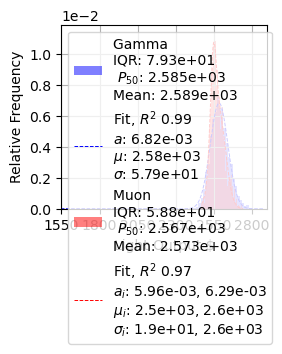

In [8]:
# Rest of the code...
    # Set the figure size based on LaTeX geometry settings
geometry_textwidth = 384  # pt
pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
plot_width = geometry_textwidth * pt_to_inch *0.5
fig, ax = plt.subplots(figsize=(plot_width, plot_width*0.9))

#mpl.rcParams['figure.figsize'] = (plot_width, plot_width*1.2)  # Adjust the height as needed (6 inches in this example)
# Create a figure and axes
ax.grid(True)  # Add a grid

ax.set_xlabel(r"Light Output $")  # Set x-axis label with units
ax.set_ylabel("Relative Frequency")  # Set y-axis label
# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1550, 2900)
plt.xticks(range(1550, 3000, 250))

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram


#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
#                                  tree_name, branch_name, save_folder, fig, ax, "red",'muon')
blue = (0, 0, 1)
dark_red = (1, 0, 0)
plot_histogram_from_folder_Landau(\
                            "../TierIIData/2023_07/Default_3mm_Na_ESRBP", \
                            tree_name, branch_name, save_folder, fig, ax, \
                            blue,r"Gamma ",0,0,0)
plot_histogram_from_folder_Landau(\
                            "../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
                            tree_name, branch_name, save_folder, fig, ax,\
                            dark_red,r"Muon ",0,0,1)

#print(data1)
# Add the legend to the plot
#ax.legend()
print(legend_labels)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set the location of the legend to upper left
plt.legend(loc='upper left')
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_3mm.pdf", bbox_inches='tight')
# Show the plot
plt.show()

In [6]:
# Rest of the code...
    # Set the figure size based on LaTeX geometry settings
geometry_textwidth = 384  # pt
pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
plot_width = geometry_textwidth * pt_to_inch *0.5
fig, ax = plt.subplots(figsize=(plot_width, plot_width*0.9))

#mpl.rcParams['figure.figsize'] = (plot_width, plot_width*1.2)  # Adjust the height as needed (6 inches in this example)
# Create a figure and axes
ax.grid(True)  # Add a grid

ax.set_xlabel(r"Light Output $\left(\si{\gamma_d/\mega\electronvolt}\right)$")  # Set x-axis label with units
ax.set_ylabel("Relative Frequency")  # Set y-axis label
# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1550, 2900)
plt.xticks(range(1550, 3000, 250))

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram


#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
#                                  tree_name, branch_name, save_folder, fig, ax, "red",'muon')
blue = (0, 0, 1)
dark_red = (1, 0, 0)
plot_histogram_from_folder_Landau(\
                            "../TierIIData/2023_07/Default_3mm_Na_ESRBP", \
                            tree_name, branch_name, save_folder, fig, ax, \
                            blue,r"Gamma \SI{0.511}{\mega\electronvolt}",0,0,0)
plot_histogram_from_folder_Landau(\
                            "../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
                            tree_name, branch_name, save_folder, fig, ax,\
                            dark_red,r"Muon \SI{2}{\mega\electronvolt}",0,0,1)

#print(data1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set the location of the legend to upper left
plt.legend(loc='upper left')
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_3mm.pdf", bbox_inches='tight')
# Show the plot
plt.show()

Reading X data
data1:
[nan, 2375.1961928216874, nan, nan, nan, 2665.3086910449856, nan, nan, nan, nan]
Edep:
[0.0, 0.07704626697914985, 0.0, 0.0, 0.0, 0.24068506666989015, 0.0, 0.0, 0.0, 0.0]
filtered data
[2572.4070450097843, 2539.138943248532, 2590.9980430528376, 2605.675146771038, 2661.4481409001955, 2568.4931506849316, 2586.105675146771, 2607.6320939334632, 2612.524461839531, 2519.569471624266]
n bins:
127
79.2563600782778 2585.127201565558 2588.6492948879472
Fit Gauss
fit_histogramG1
[1, 1927.592954990215, 551.9116697501398]
Reading X data
data1:
[2535.776403064962, 2664.694783958024, 2542.418176953612, 2553.415111491422, 2631.305728030871, 2545.6410663315223, 2570.1446852301838, 2605.842636678163, 2554.028309284218, 2578.733038205349]
Edep:
[2.3249289617468563, 4.95403829341828, 2.6407929509239425, 2.885351452195614, 2.546264361691609, 2.262887755932282, 2.5175625470363348, 2.4514143371846884, 2.3680238695924984, 3.5781136950963583]
filtered data
[2535.776403064962, 2664.69478395

ValueError: 
\left(\si{\gamma_d/\mega\electronvolt}\right)
      ^
Expected '\\right', found '\'  (at char 6), (line:1, col:7)

Error in callback <function _draw_all_if_interactive at 0x7feefc97a310> (for post_execute):


ValueError: 
\left(\si{\gamma_d/\mega\electronvolt}\right)
      ^
Expected '\\right', found '\'  (at char 6), (line:1, col:7)

ValueError: 
\left(\si{\gamma_d/\mega\electronvolt}\right)
      ^
Expected '\\right', found '\'  (at char 6), (line:1, col:7)

<Figure size 265.67x239.103 with 1 Axes>

In [33]:
# Rest of the code...

geometry_textwidth = 384  # pt
pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
plot_width = geometry_textwidth * pt_to_inch *0.5
fig, ax = plt.subplots(figsize=(plot_width, plot_width*0.9))
ax.grid(True)  # Add a grid
ax.set_xlabel(r"Light Output $\left(\si{\gamma_d/\mega\electronvolt}\right)$")  # Set x-axis label with units
ax.set_ylabel("Relative Frequency")  # Set y-axis label

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1550, 2900)
plt.xticks(range(1550, 3000, 250))

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

blue = (0, 0, 1)
dark_red = (1, 0, 0)
#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
#                                  tree_name, branch_name, save_folder, fig, ax, "red",'muon')
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Na_ESRBP", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, blue,'Gamma \SI{0.511}{\mega\electronvolt}',0,0,0)
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Muon_ESRBP", \
                                  tree_name, branch_name, save_folder, \
                                  fig, ax, dark_red,'Muon \SI{2}{\mega\electronvolt}',0,0,0)
#print(data1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set the location of the legend to upper left
plt.legend(loc='upper left')
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_FL.pdf" ,bbox_inches='tight')
# Show the plot
plt.show()

Reading X data
data1:
[2335.616438356165, 2413.24088132321, nan, nan, nan, 2450.097847358121, 2405.9789312004254, 2398.8330119603174, nan, nan]
Edep:
[0.5109999999999999, 0.29628206845557686, 0.0, 0.0, 0.0, 0.5110000000000001, 0.19659357522470242, 0.457931, 0.0, 0.0]
filtered data
[2335.616438356165, 2450.097847358121, 2432.4853228962816, 2406.0665362035224, 2464.774951076321, 2469.6673189823873, 2432.4853228962816, 2378.6692759295493, 2428.5714285714284, 2534.246575342466]
n bins:
40
75.34246575342513 2415.851272015655 2412.224716523563
Fit Gauss
fit_histogramG1
[1, 1788.160469667319, 487.0929245734152]
Reading X data
data1:
[2386.2773446930073, 2388.8718298950835, 2385.238353123995, 2422.872261547091, 2378.5537890976793, 2420.7513025713224, 2404.302373931409, 2454.0474814191784, 2467.8131745243154, 2431.0977288840913]
Edep:
[3.0319191589738606, 2.348388862807422, 3.3265019362144774, 2.749422702023256, 5.067995542187405, 2.5667651168461707, 2.3774047981550046, 2.7646164352437532, 2.40

/tmp/ipykernel_41327/1436035522.py:47: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [32]:
# Rest of the code...

geometry_textwidth = 384  # pt
pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
plot_width = geometry_textwidth * pt_to_inch *0.5
fig, ax = plt.subplots(figsize=(plot_width, plot_width*0.9))
ax.grid(True)  # Add a grid
ax.set_xlabel(r"Light Output $\left(\si{\gamma_d/\mega\electronvolt}\right)$")  # Set x-axis label with units
ax.set_ylabel("Relative Frequency")  # Set y-axis label

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1550, 2900)
plt.xticks(range(1250, 3000, 250))

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

blue = (0, 0, 1)
dark_red = (1, 0, 0)
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Na_ESRBP", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, blue,'Gamma \SI{0.511}{\mega\electronvolt}',0,0,0)
data1=plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Muon_ESRBP", \
                                  tree_name, branch_name, save_folder, fig, ax, dark_red,'Muon \SI{2}{\mega\electronvolt}',3000,0,0)
#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Muon_ESRBP_rnd", \
#                                  tree_name, branch_name, save_folder, fig,\
#                                  ax, "green",'$\mu$ \SI{2}{\mega\electronvolt} rnd',3000)
#print(data1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set the location of the legend to upper left
plt.legend(loc='upper left')
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_GC3.pdf", bbox_inches='tight')
# Show the plot
plt.show()

Reading X data
data1:
[2241.990960413766, nan, nan, nan, nan, nan, nan, nan, nan, 2256.3600782778863]
Edep:
[0.12578106021799307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.511]
filtered data
[2256.3600782778863, 2306.2622309197654, 2321.917808219178, 2289.628180039139, 2243.6399217221137, 2297.455968688845, 2244.6183953033274, 2290.606653620352, 2287.671232876712, 2301.3698630136987]
n bins:
125
70.4500978473593 2302.3483365949114 2304.0961325007297
Fit Gauss
fit_histogramG1
[1, 2306.75024582756, 174.8384648697908]
Reading X data
data1:
[2228.64394677731, inf, 2323.031616662739, 2264.936936442486, 2283.122794234241, 2320.8278950526133, 2310.6783100757607, 2239.578759807775, 2263.1239413273343, 2346.661749701468]
Edep:
[2.2764964351243466, 0.0, 2.4496007541106812, 2.2104368203132667, 2.358611640862763, 2.45925172313159, 2.692283029131836, 2.567670359801756, 2.3551516126306042, 2.5308291664768188]
filtered data
[2228.64394677731, 2323.031616662739, 2264.936936442486, 2283.122794234241, 2

/tmp/ipykernel_41327/3140468232.py:47: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [ ]:
# Rest of the code...
    # Set the figure size based on LaTeX geometry settings
geometry_textwidth = 384  # pt
pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
plot_width = geometry_textwidth * pt_to_inch *0.5
fig, ax = plt.subplots(figsize=(plot_width, plot_width*1.05))

#mpl.rcParams['figure.figsize'] = (plot_width, plot_width*1.2)  # Adjust the height as needed (6 inches in this example)
# Create a figure and axes
ax.grid(True)  # Add a grid
ax.set_xlabel(r"Light Output $\left(\si{\sum\gamma_d/\mega\electronvolt}\right)$")  # Set x-axis label with units
ax.set_ylabel("Frequency")  # Set y-axis label
# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1800, 2800)
plt.xticks(range(1800, 3000, 250))

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram


#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
#                                  tree_name, branch_name, save_folder, fig, ax, "red",'muon')
blue = (0, 0, 1)
dark_red = (1, 0, 0)
plot_histogram_from_folder_Landau(\
                            "../TierIIData/2023_07/Default_3mm_Na_ESRBP", \
                            tree_name, branch_name, save_folder, fig, ax, \
                            blue,'Gamma \SI{0.511}{\mega\electronvolt}',0,0,0)
plot_histogram_from_folder_Landau(\
                            "../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
                            tree_name, branch_name, save_folder, fig, ax,\
                            dark_red,'$\mu$ \SI{2}{\mega\electronvolt}',0,0,1)

#print(data1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set the location of the legend to upper left
plt.legend(loc='upper left')
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_3mmv2.pdf", bbox_inches='tight')
# Show the plot
plt.show()

In [ ]:
# Rest of the code...

geometry_textwidth = 384  # pt
pt_to_inch = 1.0 / 72.27  # Conversion factor from points to inches
plot_width = geometry_textwidth * pt_to_inch *0.5
fig, ax = plt.subplots(figsize=(plot_width, plot_width*0.9))
ax.grid(True)  # Add a grid
ax.set_xlabel(r"Light Output $\left(\si{\gamma_d/\mega\electronvolt}\right)$")  # Set x-axis label with units
ax.set_ylabel("Frequency")  # Set y-axis label

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1550, 2900)
#plt.xticks(range(1550, 3000, 250))

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fHits"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

blue = (0, 0, 1)
dark_red = (1, 0, 0)
#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
#                                  tree_name, branch_name, save_folder, fig, ax, "red",'muon')
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Muon_ESRBP", \
                                  tree_name, branch_name, save_folder, \
                                  fig, ax, dark_red,'$\mu$ \SI{2}{\mega\electronvolt}',30000,1,0)
#print(data1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# Set the location of the legend to upper left
plt.legend(loc='upper left')
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_FL_LC.pdf" ,bbox_inches='tight')
# Show the plot
plt.show()

In [ ]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel(r"Light Output $\left(\si{\gamma_d/\mega\electronvolt}\right)$")  # Set x-axis label with units
ax.set_ylabel("Frequency")  # Set y-axis 

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fGlueL"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram


#plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_3mm_Muon_ESRBP", \
#                                  tree_name, branch_name, save_folder, fig, ax, "red",'muon')
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Muon_ESRBP_rnd", \
                                  tree_name,"fGlueL", save_folder, fig, ax, "green",\
                                  'Glue',10000,2)

plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Muon_ESRBP_rnd", \
                                  tree_name, "fResinL", save_folder, fig, ax, "blue",\
                                  'Resin',10000,2)

plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Na_ESRBP", \
                                  tree_name, "fResinL", save_folder, fig, ax, "black",\
                                  'Resin',10000,2)

plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Na_ESRBP", \
                                  tree_name, "fGlueL", save_folder, fig, ax, "gray",\
                                  'Glue',10000,2)

plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Muon_ESRBP_rnd", \
                                  tree_name, "fDetYpos", save_folder, fig, ax, "yellow",\
                                  'DETY',10000,2)

plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_GC3_Muon_ESRBP_rnd", \
                                  tree_name, "fDetXpos", save_folder, fig, ax, "red",\
                                  'DETX',10000,2)

print(data1[0:10])
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
#plt.savefig("histogram_defGC3rnd.png")
# Show the plot
plt.show()

In [ ]:
# Rest of the code...

# Create the figure and axes
textwidth = 16.51
# Create a figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.35))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_xlabel("Light Output [\si{$\gamma_d$\per\mega\electronvolt}]")  # Set x-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fHits"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

#def plot_histogram_from_folder_Landau(folder, tree_name, branch_name, save_folder, \
#                                      fig, ax, color, legends, limit=0, fit=0, sfit=1):

plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Muon_ESRBP", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "blue",'Gamma \SI{0.511}{\mega\electronvolt}',400000,1,0)
print(data1[0:10])
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/Def_Hist_Na_Muon_rnd_GC3.pdf")
# Show the plot
plt.show()

In [ ]:
folder = "../NSGAIIData/2307/G11_objLOP50_Acte_NoYSym_ESRBP_SiMP_3x3_60Evts_Spline_23-07-24_SOLV200"
tree_name = "EndOfEvent"
branch_name = "fHits"
data1 = readRootDataFromFolder(folder, tree_name, branch_name)
data1

In [ ]:
# Rest of the code...

# Create the figure and axes
textwidth = 16.51
# Create a figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.35))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_xlabel("Light Output [\si{$\sum\gamma_d$\per\mega\electronvolt}]")  # Set x-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

#def plot_histogram_from_folder_Landau(folder, tree_name, branch_name, save_folder, \
#                                      fig, ax, color, legends, limit=0, fit=0, sfit=1):

plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/G11_objLOP50_Acte_NoYSym_ESRBP_SiMP_3x3_60Evts_Spline_23-07-24_SOLV200", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "blue",'\ce{^22Na} \SI{0.511}{\mega\electronvolt}',400000,2,0)


# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/RstHist_LO_V200.pdf")
# Show the plot
plt.show()

In [ ]:
# Rest of the code...

# Create the figure and axes
textwidth = 16.51
# Create a figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.35))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_xlabel("Light Output [\si{$\sum\gamma_d$\per\mega\electronvolt}]")  # Set x-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fHits"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

#def plot_histogram_from_folder_Landau(folder, tree_name, branch_name, save_folder, \
#                                      fig, ax, color, legends, limit=0, fit=0, sfit=1):
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Muon_ESRBP", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "red",'$\gamma$ \SI{0.511}{\mega\electronvolt}',400000,2,0)
plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/Sol_LStAvg", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "blue",'$\gamma$ \SI{0.511}{\mega\electronvolt}',75000,2,0)
plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/G11_objLStP50_Acte_NoYSym_ESRBP_SiMP_3x3_60Evts_Spline_23-07-27_SOLV513", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "green",'$\gamma$ \SI{0.511}{\mega\electronvolt}',75000,2,0)
plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/Sol_LC", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "purple",'$\gamma$ \SI{0.511}{\mega\electronvolt}',75000,2,0)
plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/Sol_LCAvg", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "yellow",'$\gamma$ \SI{0.511}{\mega\electronvolt}',75000,2,0)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/RstHist_LSt_V513.pdf")
# Show the plot
plt.show()

In [ ]:
# Rest of the code...

# Create the figure and axes
textwidth = 16.51
# Create a figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.35))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_xlabel("Light Output [\si{$\sum\gamma_d$\per\mega\electronvolt}]")  # Set x-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fHits"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

#def plot_histogram_from_folder_Landau(folder, tree_name, branch_name, save_folder, \
#                                      fig, ax, color, legends, limit=0, fit=0, sfit=1):
plot_histogram_from_folder_Landau("../TierIIData/2023_07/Default_FL_Muon_ESRBP", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "red",'\ce{^22Na} \SI{0.511}{\mega\electronvolt}',400000,2,0)
plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/Sol_LStP50", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "blue",'\ce{^22Na} \SI{0.511}{\mega\electronvolt}',75000,2,0)
plot_histogram_from_folder_Landau("../NSGAIIData/2307/Solutions/G11_objLStP50_Acte_NoYSym_ESRBP_SiMP_3x3_60Evts_Spline_23-07-27_SOLV513", \
                                  tree_name, branch_name, save_folder,\
                                  fig, ax, "green",'\ce{^22Na} \SI{0.511}{\mega\electronvolt}',75000,2,0)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("Figures/2307/DefHists/RstHist_LSt_V513.pdf")
# Show the plot
plt.show()